In [101]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import functions from the utils.py file
from utils import *

folderpath = 'plant_data/Hiver 2024/Fichier RAW/'
filename = 'Acer pensylvanicum 2024-02-28.raw'
# get all filenames in the folder that ends with .raw
filenames = [f for f in os.listdir(folderpath) if f.endswith('.raw')]
rnd_filename = np.random.choice(filenames)
data = np.fromfile(folderpath + rnd_filename, dtype=np.float32)
# remove nan values
data = data[~np.isnan(data)]
sf = 256

## Temporal Clustering using Spectral Centroid

In [102]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def generate_segments(data, n_segments=64):
    feature = librosa.feature.spectral_centroid(y=data, sr=sf, n_fft=2000)
    bounds = librosa.segment.agglomerative(feature, n_segments)
    bound_times = librosa.frames_to_time(bounds, sr=sf)
    bound_times = sf*bound_times
    segments = segment_time_series(data, bound_times)
    segments = [segment[~np.isnan(segment)] for segment in segments]
    return segments, bound_times

def compute_avg_spectral_centroid(segments):
    spectral_centroids = []
    sc_avg = []
    sc_range = []
    for segment in segments:
        spectral_centroids.append(librosa.feature.spectral_centroid(y=segment, sr=sf, n_fft=2000)[0])
        sc_avg.append(np.nanmean(spectral_centroids[-1]))
        sc_range.append(np.nanmax(spectral_centroids[-1]) - np.nanmin(spectral_centroids[-1]))
    return sc_avg, sc_range

def compute_avg_spectral_rolloff(segments):
    spectral_rolloffs = []
    sr_avg = []
    for segment in segments:
        spectral_rolloffs.append(librosa.feature.spectral_rolloff(y=segment, sr=sf, n_fft=2000)[0])
        sr_avg.append(np.nanmean(spectral_rolloffs[-1]))
    return sr_avg

segments, bound_times = generate_segments(data, n_segments=64)
sc_avg, sc_range = compute_avg_spectral_centroid(segments)


# plot the time series and the change points
#plt.plot(data_)
#plt.vlines(bound_times, data_.min(), data_.max(), color='r', linestyle='--', label='Change Points')
#plt.show()



c:\Users\User\anaconda3\envs\goofi\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2000 is too small for input signal of length=0
  return f(*args, **kwargs)
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2000 is too small for input signal of length=1536
  return f(*args, **kwargs)


## Melody from averaged spectral centroids across segments

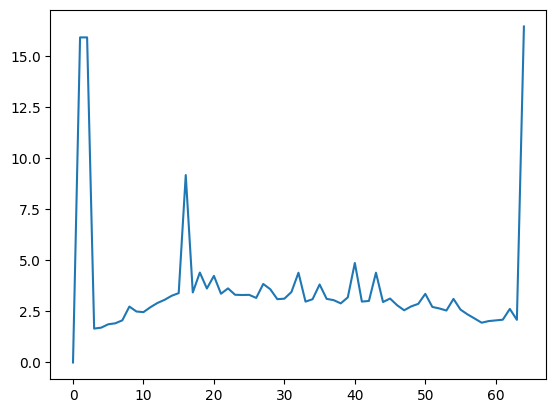

In [96]:
plt.plot(sc_avg)

In [108]:

n_oct_up = 6
# create folder 'spectral_centroid_melodies' in music_output folder
if not os.path.exists('music_output/spectral_centroid_melodies'):
    os.makedirs('music_output/spectral_centroid_melodies')

def freq2midi(frequency):
    return 69 + 12*np.log2(frequency/440)

def generate_melody(freqs, velocities, n_oct_up=6, filename='test', duration=40):
    sc_range = velocities
    sc_avg = freqs
    # rescale sc_range between 10 and 110 fo velocity
    sc_range_rescaled = np.array(sc_range) - np.nanmin(sc_range)
    sc_range_rescaled = sc_range_rescaled / np.nanmax(sc_range_rescaled) * 100
    sc_range_rescaled = [int(vel) for vel in sc_range_rescaled]

    # shift all sc_avg values by 3 octaves
    sc_avg_shifted = np.array(sc_avg) * 2**n_oct_up
    midi_notes = [freq2midi(sc) for sc in sc_avg_shifted]
    # remove -inf values
    midi_notes = midi_notes[1:]
    # if midi note below 0, set it to 0
    midi_notes = [max(0, note) for note in midi_notes]
    # create MIDI file with the notes and corresponding time stamps
    from mido import Message, MidiFile, MidiTrack
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    bound_times_rescaled = bound_times / bound_times[-1] * duration
    bound_times_rescaled = bound_times_rescaled * 480

    for i, note, vel in zip(range(len(midi_notes)), midi_notes, sc_range_rescaled):
        try:
            track.append(Message('note_on', note=int(note), velocity=vel, time=int(bound_times_rescaled[i+1]-bound_times_rescaled[i])))
            track.append(Message('note_off', note=int(note), velocity=vel, time=int(bound_times_rescaled[i+1]-bound_times_rescaled[i])))
        except IndexError:
            pass
    mid.save(f'music_output/spectral_centroid_melodies/SC_mel_{filename}.mid')
    
    # generate melodies for all files
for filename in filenames:
    data = np.fromfile(folderpath + filename, dtype=np.float32)
    data = data[~np.isnan(data)]
    if len(data) < 256:
        continue
    segments, bound_times = generate_segments(data, n_segments=64)
    sc_avg, sc_range = compute_avg_spectral_centroid(segments)
    generate_melody(sc_avg, sc_range, n_oct_up, filename=filename, duration=25)
    

c:\Users\User\anaconda3\envs\goofi\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2000 is too small for input signal of length=0
  return f(*args, **kwargs)
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2000 is too small for input signal of length=512
  return f(*args, **kwargs)
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2000 is too small for input signal of length=413
  return f(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_5992\2319005193.py:7: RuntimeWarning: divide by zero encountered in log2
  return 69 + 12*np.log2(frequency/440)
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2000 is too small for input signal of length=0
  return f(*args, **kwargs)
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2000 is too small for inp

## Generate chords based on Spectral Peaks

In [112]:

from biotuner.biotuner_object import compute_biotuner
from biotuner.peaks_extraction import EMD_eeg
def extract_chords(segments):
    # remove nans from segments
    chords = []
    for segment in segments[1:]:
        if np.isnan(segment).any():
            segment = segment[~np.isnan(segment)]
        try:
            bt = compute_biotuner(sf=sf, data=segment, peaks_function='cepstrum', precision=0.1)
            bt.peaks_extraction(min_freq=1, max_freq=100)
        except ValueError:
            continue
        chord = bt.peaks[1:]
        chords.append(chord)
    return chords

In [115]:
from biotuner.biotuner_utils import chords_to_ratios
from biotuner.biotuner_utils import create_midi, rebound

#chords_ratios, chords_bounded = chords_to_ratios(chords, harm_limit=2, spread=False)
if not os.path.exists('music_output/cepstral_chords'):
    os.makedirs('music_output/cepstral_chords')
    
def chords_to_MIDI(chords, n_oct_up=7, max_beat_duration=1.5, fname='test_chords', microtonal=True):
    n_chords = len(chords)
    mult = 2**n_oct_up
    new_chords = []
    for chord in chords[1:n_chords]:
        # Take the original frequencies and rebound them within one octave range
        c = [rebound(x, low=np.min(chord)-1, high=np.min(chord)*2, octave=2) for x in chord]
        # Then, move the chord n octaves up to be in the hearing range
        c = [np.int(x*mult) for x in c]
        new_chords.append(c)

    bound_times_rescaled = bound_times / bound_times[-1] * 1000
    durations = [bound_times_rescaled[i+1]-bound_times_rescaled[i] for i in range(n_chords-1)]
    # rescale durations between 0.1 and 2
    durations = [d/np.max(durations) for d in durations]
    durations = [d*max_beat_duration for d in durations]
    fname = f"music_output/cepstral_chords/chords_{fname}.mid"
    midi_file = create_midi(new_chords, durations, microtonal=microtonal, filename=fname)
    return midi_file

for filename in filenames:
    data = np.fromfile(folderpath + filename, dtype=np.float32)
    data = data[~np.isnan(data)]
    if len(data) < 256:
        continue
    segments, bound_times = generate_segments(data, n_segments=24)
    chords = extract_chords(segments)
    chords_to_MIDI(chords, n_oct_up=8, fname=filename, microtonal=False, max_beat_duration=0.5)

c:\Users\User\anaconda3\envs\goofi\lib\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\Users\User\AppData\Local\Temp\ipykernel_5992\2380242224.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c = [np.int(x*mult) for x in c]
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(valu